In [6]:
# DATA DOWNLOAD
# NBA API + FILTERING
# filtering to only include players where min > 15

# Here we choose stats that capture how a player plays, not just how good he is: usage, assists, threes, blocks, etc.

!pip install nba_api pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from nba_api.stats.endpoints import leaguedashplayerstats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")

# Features used for clustering
FEATURES = [
    'PTS',      # scoring
    'REB',      # total rebounds
    'AST',      # assists
    'STL',      # steals
    'BLK',      # blocks
    'FG_PCT',   # overall efficiency
    'FG3_PCT',  # 3pt efficiency
    'FT_PCT',   # FT efficiency
    'USG_PCT',  # usage / on-ball load
    'TS_PCT',   # true shooting
    'AST_PCT',  # playmaking share
    'FG3A',     # 3PA volume
    'FTA',      # free-throw volume
]

# Stats we use in the archetype summary heatmaps
STATS_FOR_SUMMARY = ['PTS', 'REB', 'AST', 'FG3A', 'FTA', 'USG_PCT', 'BLK']

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Use LeagueDashPlayerStats twice:
# once for base per game stats
# once for advanced per game stats

# We combine base and advanced stats and then filter to players who actually play meaningful minutes,so the clusters aren’t polluted by garbage-time guys.
# garbage-time guys is a term for the final period of a blowout game where the outcome is virtually decided,the leading team rests stars,
# and bench players get playing time, leading to looser defense and potentially inflated stats for reserves.

def get_nba_data(season: str = "2024-25", min_minutes: float = 15.0) -> pd.DataFrame:
    """
    Fetch per-game base + advanced stats for a given season and filter to players above a minutes-per-game threshold.
    """
    print(f"Fetching data for {season} season via NBA API...")

    # base box-score stats (per game)
    base = leaguedashplayerstats.LeagueDashPlayerStats(
        season=season,
        per_mode_detailed='PerGame',
        season_type_all_star='Regular Season',
        measure_type_detailed_defense='Base'
    ).get_data_frames()[0]

    # advanced stats (per game)
    adv = leaguedashplayerstats.LeagueDashPlayerStats(
        season=season,
        per_mode_detailed='PerGame',
        season_type_all_star='Regular Season',
        measure_type_detailed_defense='Advanced'
    ).get_data_frames()[0]

    # keep only some advanced columns (we mostly care about USG/TS/AST_PCT etc.)
    adv_cols_to_use = [
        'PLAYER_ID', 'PLAYER_NAME',
        'OFF_RATING', 'DEF_RATING', 'NET_RATING',
        'TS_PCT', 'USG_PCT', 'AST_PCT', 'REB_PCT'
    ]

    full_df = pd.merge(
        base,
        adv[adv_cols_to_use],
        on=['PLAYER_ID', 'PLAYER_NAME'],
        how='left'
    )

    # filter by minutes per game for rotation level players
    full_df['MIN'] = full_df['MIN'].astype(float)
    df_filtered = full_df[full_df['MIN'] > min_minutes].reset_index(drop=True)

    print(f"Players with MIN > {min_minutes}: {len(df_filtered)}")
    return df_filtered

Fetching data for 2024-25 season via NBA API...
Players with MIN > 15.0: 365


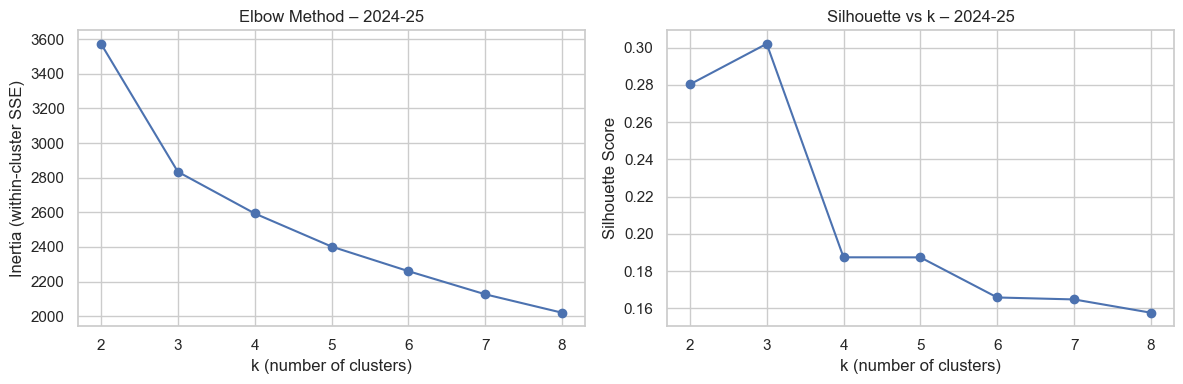

In [8]:
# elbow method + silhouette vs k (choosing number of clusters) focusing on the 2024-2025 season

SEASON_FOR_K = "2024-25"

df_k = get_nba_data(SEASON_FOR_K, min_minutes=15.0)

# Features + scaling
X_k = df_k[FEATURES].copy()
X_k = X_k.fillna(X_k.median())

scaler_k = StandardScaler()
X_k_scaled = scaler_k.fit_transform(X_k)

# Loop over candidate k values
inertias = []
sil_scores = []
K_range = range(2, 9)  # k = 2..8

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_k_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_k_scaled, labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title(f"Elbow Method – {SEASON_FOR_K}")

plt.subplot(1, 2, 2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette Score")
plt.title(f"Silhouette vs k – {SEASON_FOR_K}")

plt.tight_layout()
plt.show()

# Final choice of k for the rest of the project
K_FINAL = 5


The elbow plot of inertia bends around k = 5.
The silhouette curve peaks around k = 3 then slowly declines
We chose k = 5 as a balance because its still a reasonably high silhouette but enough clusters to matche basketball roles (the amount of players per team on the court at once is 5 as well).

In [9]:
# Turning numeric clusters into basketball roles
def get_archetype_names(df_in: pd.DataFrame, cluster_col: str = 'Cluster') -> dict:
    """
    Analyze cluster-level averages to assign readable archetype names.
    Uses:
        - USG_PCT (ball dominance)
        - AST (raw playmaking)
        - REB / BLK (big / rim protection)
        - FG3A (shooting volume)
    """
    # cluster-level means of key stats
    stats = df_in.groupby(cluster_col)[['USG_PCT', 'AST', 'REB', 'BLK', 'FG3A']].mean()

    mapping = {}
    remaining = list(stats.index)

    # A. Rim Protector: highest combo of rebounds + blocks
    stats['Big_Score'] = stats['REB'] + 1.5 * stats['BLK']
    rim_id = stats['Big_Score'].idxmax()
    mapping[rim_id] = "Rim Protector"
    remaining.remove(rim_id)

    # B. Primary Creator: highest assists among remaining
    creator_id = stats.loc[remaining, 'AST'].idxmax()
    mapping[creator_id] = "Primary Creator"
    remaining.remove(creator_id)

    # C. Role Player: lowest usage among remaining
    role_id = stats.loc[remaining, 'USG_PCT'].idxmin()
    mapping[role_id] = "Role Player"
    remaining.remove(role_id)

    # D. Floor Spacer: highest 3PA among remaining
    shooter_id = stats.loc[remaining, 'FG3A'].idxmax()
    mapping[shooter_id] = "Floor Spacer"
    remaining.remove(shooter_id)

    # E. Versatile: the cluster left over (usually balanced stat line)
    if remaining:
        mapping[remaining[0]] = "Versatile"

    print("Cluster -> Archetype mapping:", mapping)
    return mapping

In [10]:
# reusable function so we can plug in any season
# pipeline for a specific year/ season

def run_pipeline_for_season(season: str = "2024-25", k: int = 5, min_minutes: float = 15.0):
    """
    Run the full clustering pipeline for a single NBA season.

    Returns a dict with:
        - 'df': main DataFrame with Cluster + Archetype
        - 'pca_df': 2D PCA coordinates + Archetype (for plotting)
        - 'scaler', 'kmeans', 'pca', 'name_map'
    """
    print(f"\nRunning pipeline for season {season}")
    df = get_nba_data(season=season, min_minutes=min_minutes)

    # Features + scaling
    X = df[FEATURES].copy()
    X = X.fillna(X.median())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    df['Cluster'] = labels

    # PCA for visualization
    pca = PCA(n_components=2, random_state=42)
    pca_coords = pca.fit_transform(X_scaled)
    variance_2d = pca.explained_variance_ratio_.sum()
    print(f"Variance explained by first 2 PCs ({season}): {variance_2d:.2f}")

    pca_df = pd.DataFrame(pca_coords, columns=['PC1', 'PC2'])
    pca_df['PLAYER_NAME'] = df['PLAYER_NAME'].values
    pca_df['Cluster'] = labels

    # map clusters to archetypes
    name_map = get_archetype_names(df, cluster_col='Cluster')
    df['Archetype'] = df['Cluster'].map(name_map)
    pca_df['Archetype'] = pca_df['Cluster'].map(name_map)

    return {
        "df": df,
        "pca_df": pca_df,
        "scaler": scaler,
        "kmeans": kmeans,
        "pca": pca,
        "name_map": name_map,
    }

In [11]:
#running the pipeline and function for 2024-25 and 2023-24 season
#doing this so we can compare roles across years and see if our archetypes are stable

SEASONS = ["2024-25", "2023-24"]
MIN_MINUTES = 15.0  # keep consistent everywhere

results_by_season = {}

for season in SEASONS:
    results_by_season[season] = run_pipeline_for_season(
        season = season,
        k = K_FINAL,
        min_minutes = MIN_MINUTES,
    )


Running pipeline for season 2024-25
Fetching data for 2024-25 season via NBA API...
Players with MIN > 15.0: 365
Variance explained by first 2 PCs (2024-25): 0.60
Cluster -> Archetype mapping: {np.int32(2): 'Rim Protector', np.int32(3): 'Primary Creator', np.int32(1): 'Role Player', np.int32(4): 'Floor Spacer', 0: 'Versatile'}

Running pipeline for season 2023-24
Fetching data for 2023-24 season via NBA API...
Players with MIN > 15.0: 336
Variance explained by first 2 PCs (2023-24): 0.59
Cluster -> Archetype mapping: {np.int32(0): 'Rim Protector', np.int32(1): 'Primary Creator', np.int32(3): 'Role Player', np.int32(2): 'Floor Spacer', 4: 'Versatile'}


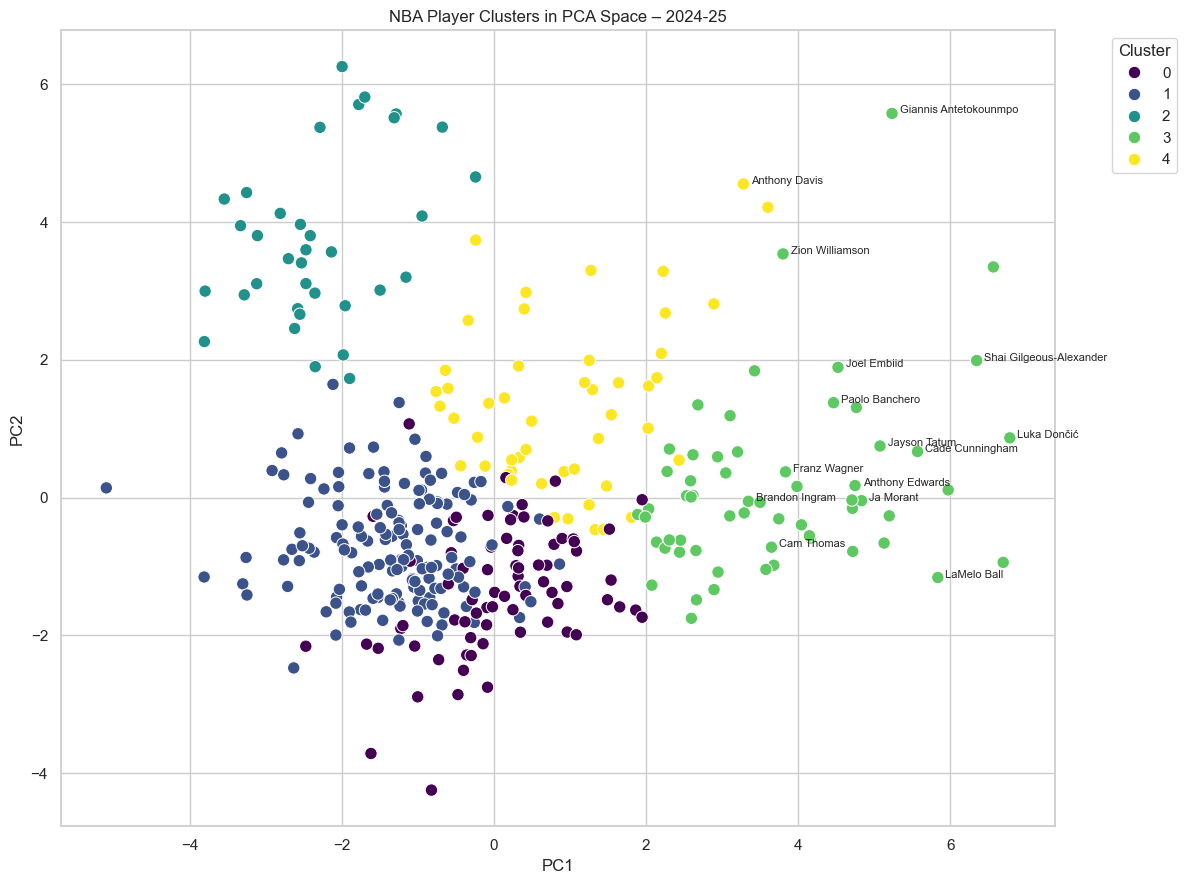

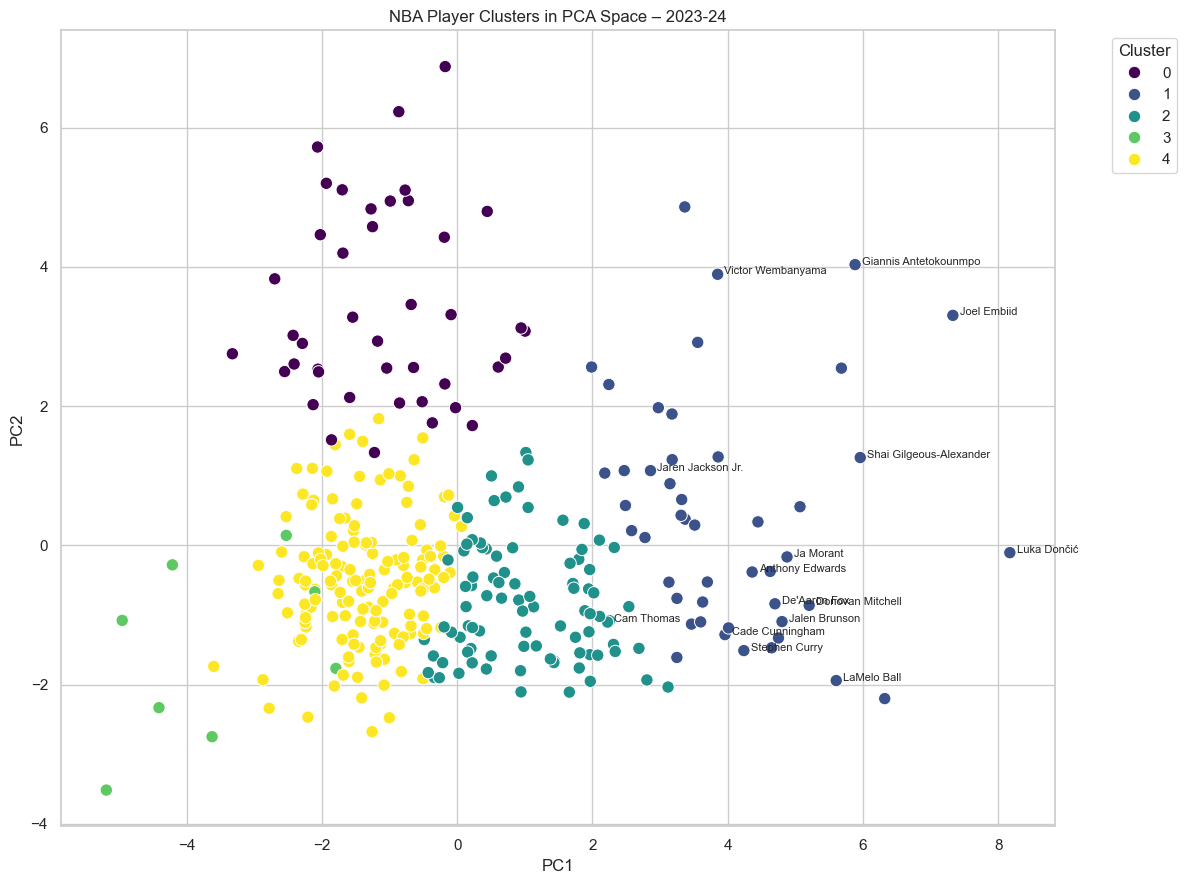

In [12]:
# numeric KMeans cluster with labels for high-usage stars
# shows the raw KMeans clusters without the archetype names, and highlights high-usage stars
# lets us check that stars with similar roles are ending up in similar numeric clusters

for season, res in results_by_season.items():
    pca_df = res["pca_df"].copy()
    df_season = res["df"]

    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        x='PC1',
        y='PC2',
        hue='Cluster',
        data=pca_df,
        palette='viridis',
        s=80
    )

    # Label the top usage players in that season
    top_usage_players = df_season.nlargest(15, 'USG_PCT')['PLAYER_NAME'].tolist()
    for _, row in pca_df.iterrows():
        if row['PLAYER_NAME'] in top_usage_players:
            plt.text(
                row['PC1'] + 0.1,
                row['PC2'],
                row['PLAYER_NAME'],
                fontsize=8
            )

    plt.title(f'NBA Player Clusters in PCA Space – {season}')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

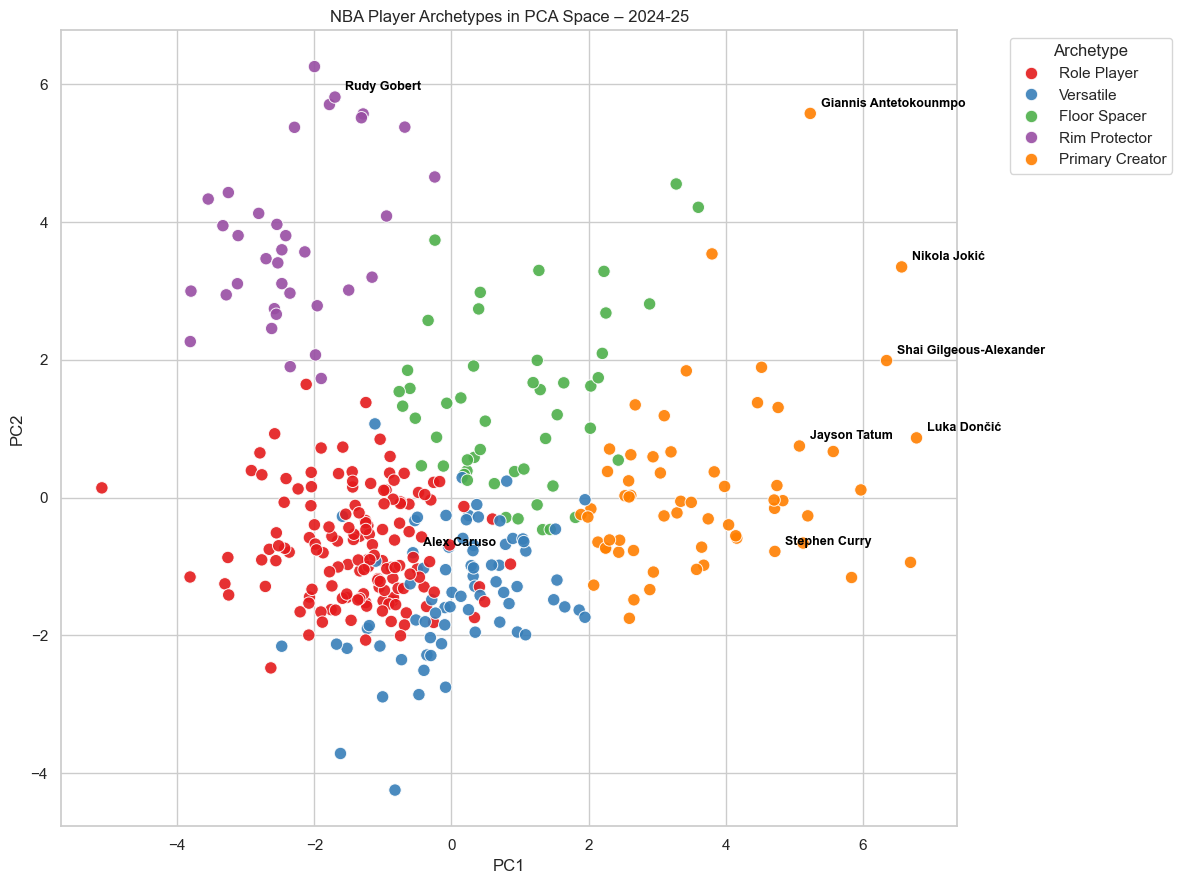

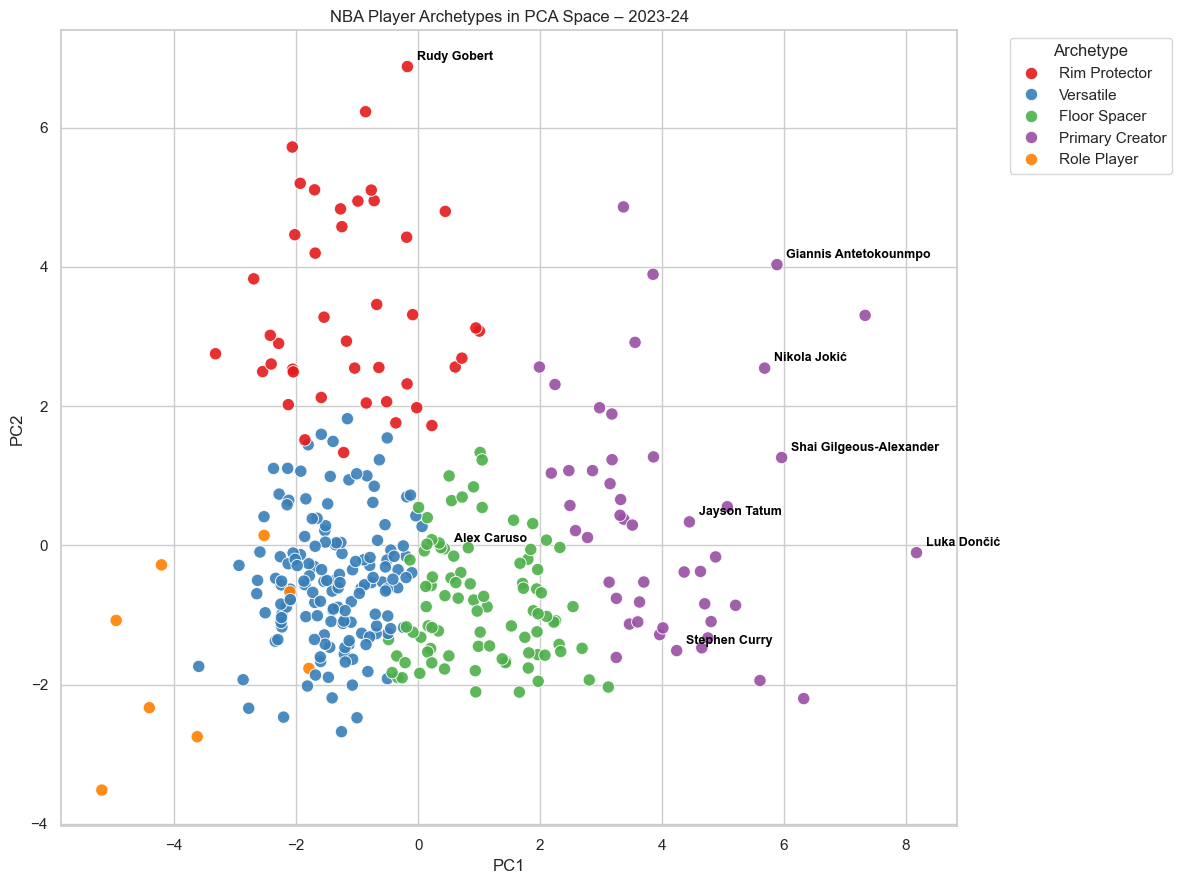

In [13]:
# PCA plots colored by archetype, with key players labeled
# This connects the data back to basketball
# like we can tell a specific region is for primary creators because luka and curry are there

# Defining example_players which are big basketball stars
example_players = [
    "Nikola Jokić",
    "Giannis Antetokounmpo",
    "Luka Dončić",
    "Stephen Curry",
    "Jayson Tatum",
    "Rudy Gobert",
    "Shai Gilgeous-Alexander",
    "Alex Caruso",
]

for season, res in results_by_season.items():
    pca_df = res["pca_df"].copy()

    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        x='PC1',
        y='PC2',
        hue='Archetype',
        data=pca_df,
        palette='Set1',
        s=80,
        alpha=0.9
    )

    # Label a few well-known players to interpret the space
    for _, row in pca_df.iterrows():
        if row['PLAYER_NAME'] in example_players:
            plt.text(
                row['PC1'] + 0.15,
                row['PC2'] + 0.10,
                row['PLAYER_NAME'],
                fontsize=9,
                weight='bold',
                color='black'
            )

    plt.title(f'NBA Player Archetypes in PCA Space – {season}')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [14]:
# Heatmaps for each season archetype
# These tables tell us why the model thinks these roles are different

for season, res in results_by_season.items():
    df_season = res["df"]

    summary = (
        df_season
        .groupby('Archetype')[STATS_FOR_SUMMARY]
        .mean()
        .sort_index()
    )

    print(f"\nAverage stats by archetype : {season}")
    display(
        summary.style
        .set_caption(f"Average stats by archetype : {season}")
        .background_gradient(cmap='coolwarm')
    )



Average stats by archetype : 2024-25


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Archetype,,,,,,,
Floor Spacer,16.304082,7.112245,2.840816,4.077551,3.379592,0.216122,0.906122
Primary Creator,22.213115,5.257377,5.621311,6.726230,5.052459,0.274180,0.455738
Rim Protector,8.860000,7.502857,1.465714,0.225714,2.080000,0.149286,1.074286
Role Player,8.501379,3.609655,1.564138,3.725517,1.247586,0.157310,0.369655
Versatile,9.464000,3.189333,3.578667,3.825333,1.692000,0.184053,0.348000



Average stats by archetype : 2023-24


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Archetype,,,,,,,
Floor Spacer,14.672222,4.161111,3.857778,5.137778,2.526667,0.213433,0.397778
Primary Creator,24.057447,6.623404,5.868085,5.661702,5.785106,0.278574,0.761702
Rim Protector,10.271429,7.585714,1.695238,0.828571,2.297619,0.160643,1.159524
Role Player,3.550000,3.525000,1.425000,1.650000,0.500000,0.133875,0.350000
Versatile,7.958389,3.489933,1.743624,3.138255,1.215436,0.153570,0.404027


In [15]:
# Collect per-season summary tables
# Stability analysis across different seasons

# It shows that the roles we found aren’t just random artifacts of one season as they show up with very similar stat profiles in both years

summaries = {}
for season, res in results_by_season.items():
    df_season = res["df"]
    summaries[season] = (
        df_season
        .groupby('Archetype')[STATS_FOR_SUMMARY]
        .mean()
        .sort_index()
    )

# Roles we want to compare across seasons
core_roles = ["Primary Creator", "Rim Protector", "Floor Spacer"]

for role in core_roles:
    print(f"\nStability analysis for '{role}'")
    for season in SEASONS:
        if role in summaries[season].index:
            row = summaries[season].loc[role]
            print(f"\n{season}:")
            display(row.to_frame(name=role).T.style.background_gradient(cmap='coolwarm'))
        else:
            print(f"\n{season}: role '{role}' not found in this season's clusters.")


Stability analysis for 'Primary Creator'

2024-25:


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Primary Creator,22.213115,5.257377,5.621311,6.726230,5.052459,0.274180,0.455738



2023-24:


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Primary Creator,24.057447,6.623404,5.868085,5.661702,5.785106,0.278574,0.761702



Stability analysis for 'Rim Protector'

2024-25:


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Rim Protector,8.860000,7.502857,1.465714,0.225714,2.080000,0.149286,1.074286



2023-24:


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Rim Protector,10.271429,7.585714,1.695238,0.828571,2.297619,0.160643,1.159524



Stability analysis for 'Floor Spacer'

2024-25:


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Floor Spacer,16.304082,7.112245,2.840816,4.077551,3.379592,0.216122,0.906122



2023-24:


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Floor Spacer,14.672222,4.161111,3.857778,5.137778,2.526667,0.213433,0.397778
